In [11]:
import numpy as np
%pylab
%matplotlib inline

from PIL import Image
from Functions import image_processing as ip
from Functions import seed_detection as sd
from Functions import seeded_region_growing as srg
import skimage.io as sk

# from collections import Counter

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


C:\Users\ijung\anaconda3\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['test']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [12]:
image = sk.imread("Data/N2DH-GOWT1/img/t01.tif") #Bild laden
image_resize = ip.img_resize(image, 500, 500)


C:\Users\ijung\anaconda3\lib\site-packages\skimage\external\tifffile\tifffile.py:2618: RuntimeWarning: py_decodelzw encountered unexpected end of stream
  strip = decompress(strip)


C:\Users\ijung\PycharmProjects\2021-topic-04-team-04\Functions\seed_detection.py:51: RuntimeWarning: invalid value encountered in ubyte_scalars
  neighborhood_distance.append((img[p] - img[i, j]) / img[p])  # adds relative euclidean distance to list
C:\Users\ijung\PycharmProjects\2021-topic-04-team-04\Functions\seed_detection.py:51: RuntimeWarning: overflow encountered in ubyte_scalars
  neighborhood_distance.append((img[p] - img[i, j]) / img[p])  # adds relative euclidean distance to list
C:\Users\ijung\PycharmProjects\2021-topic-04-team-04\Functions\seed_detection.py:51: RuntimeWarning: divide by zero encountered in ubyte_scalars
  neighborhood_distance.append((img[p] - img[i, j]) / img[p])  # adds relative euclidean distance to list


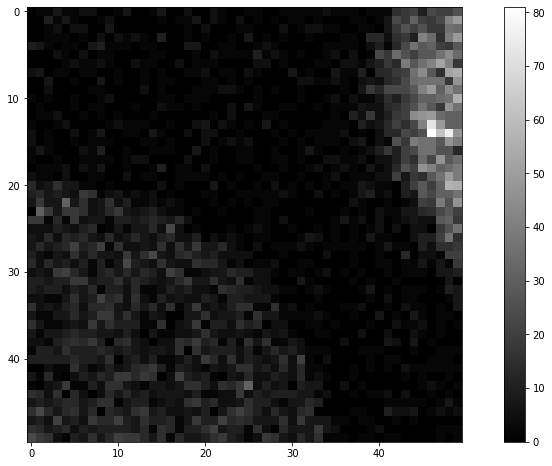

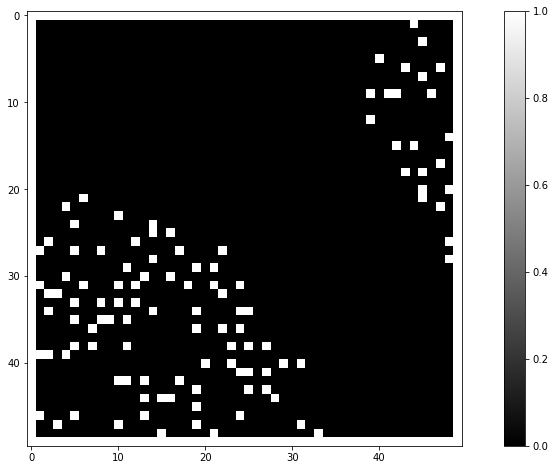

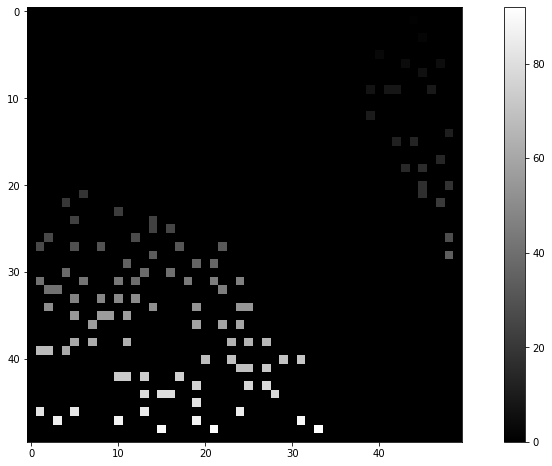

In [13]:
img_small = image[300:350, 400:450]
ip.show_image(img_small, 15, 8)
img_r = sd.seeds(img_small, 0.1, 1)
ip.show_image(img_r, 15, 8)
img_r = sd.seed_merging(img_r)
ip.show_image(img_r, 15, 8)

366
368
368
368
368
369
370
371
370
369
368
368
369
370
371
372
372
372
373
373
374
374
375
376
375
375
375
374
376
378
379
379
379
380
381
380
380
382
381
382
382
382
381
381
380
382
381
380
380
379
379
379
379
378
378
377
376
375
375
374
373
373
373
375
376
376
375
375
374
373
373
373
373
374
373
373
373
375
377
377
376
376
375
375
377
379
378
377
377
379
378
378
380
380
379
378
378
377
377
376
375
376
375
374
373
372
372
372
371
373
372
372
373
373
374
374
374
374
373
373
373
372
373
375
376
375
375
375
374
373
374
375
374
375
374
375
375
376
376
376
378
379
380
382
382
382
381
383
384
386
387
388
387
387
388
389
390
391
393
392
394
396
397
397
397
396
395
394
394
394
393
394
393
392
391
391
390
389
388
387
386
385
385
385
387
386
387
387
388
387
386
386
385
384
384
383
383
384
384
383
383
384
385
385
384
384
385
385
385
386
387
386
386
385
386
386
387
386
385
384
384
383
384
386
386
387
388
390
389
389
390
389
389
388
387
386
387
386
386
386
387
386
386
385
385
385
385
385
385
387


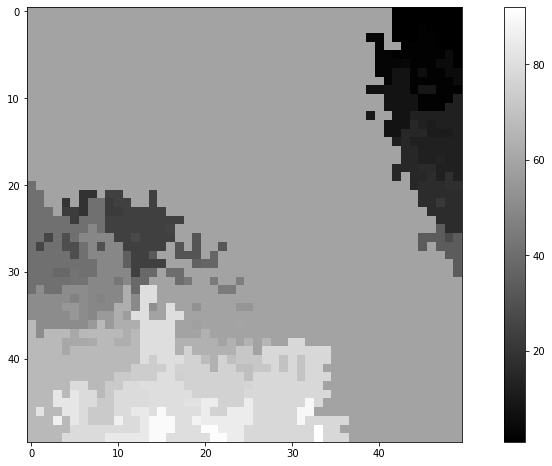

In [14]:
img_r = srg.region_growing(img_small, img_r)
ip.show_image(img_r, 15, 8)


In [15]:
#region-merging

def region_distance(img, reg):
    """
    calculates distance between all regions
    :param img: intensity values (2d array)
    :param reg: region numbers (2d array)
    :return: 2d array with distances between all regions, only in upper pyramid
    (region numbers are row and col number)
    inter_region_distances is upper triangle matrix with mean intensity distances between regions (2d array)
    mean values of all regions (list of floats)
    """

    max_region = max(reg.flatten())
    max_intensity = np.amax(img)
    inter_region_distances = np.ones((int(max_region), int(max_region)))
    means = srg.mean_region(img, reg)

    for row_number in range(0, int(max_region)):
        for col_number in range(0, int(max_region)):
            if is_upper_triangle(col_number,row_number):
                inter_region_distances[row_number][col_number] = distance_between_regions(row_number,col_number,max_intensity, means)
    return inter_region_distances, means

def is_upper_triangle(col_number, row_number):
    if col_number > row_number:
        return True
    return False

def distance_between_regions(region1, region2, max_intensity, means):
    distance = abs(means[region1] - means[region2]) / (max_intensity)
    return distance

#print(srg.mean_region(img_small, img_r))

[23.794117647058822, 31.085714285714285, 14.272727272727273, 39.0, 48.5, 44.0, 15.5, 18.045454545454547, 45.0, 18.0, 73.0, 26.0, 36.26470588235294, 47.0, 20.0, 44.0, 26.90909090909091, 53.666666666666664, 15.75, 31.0, 39.0, 15.333333333333334, 18.0, 7.688888888888889, 23.0, 13.0, 13.0, 36.0, 15.25, 20.0, 13.5, 13.0, 23.0, 15.307692307692308, 20.5, 15.0, 12.0, 19.0, 11.8, 16.0, 8.222222222222221, 16.333333333333332, 15.0, 18.0, 14.333333333333334, 15.0, 15.0, 20.0, 9.794117647058824, 14.0, 5.571428571428571, 13.0, 18.0, 15.0, 12.0, 17.25, 15.0, 18.0, 2.081555834378921, 15.0, 13.8, 18.0, 8.818181818181818, 12.066666666666666, 15.0, 15.0, 8.092783505154639, 18.0, 14.5, 14.0, 15.333333333333334, 7.714285714285714, 13.76923076923077, 14.0, 20.0, 7.257142857142857, 31.0, 6.359550561797753, 7.428571428571429, 4.983870967741935, 16.5, 23.0, 12.75, 15.88888888888889, 12.38888888888889, 20.0, 20.0, 18.0, 14.75, 10.555555555555555, 17.0, 16.5]


In [16]:
def one_merged_region_mean(img, reg, region_number):
    """
    calculates the mean of changed region
    :param img: intensity values (2d array)
    :param reg: region numbers (2d array)
    :param region_number: number of the changed region (int)
    :return: mean value of changed position (float)
    """
    pos_new_reg = np.where(reg == region_number)
    single_mean = np.mean(img[pos_new_reg[0],pos_new_reg[1]])
    return single_mean


In [17]:
def region_distance_new(img, reg, pos_min_dist, means, inter_region_distances):
    """
    updates array of distances of mean intensity values between all changed regions
    :param img: intensity values (2d array)
    :param reg: region numbers (2d array)
    :param pos_min_dist: region number of cha(tuple(x,y))
    :param means:
    :param inter_region_distances:
    :return:
    """

    region_count = inter_region_distances.shape[0]
    maximal_intensity = np.amax(img)
    changed_region1 = int(pos_min_dist[0]) # Regions Nummer 1 die übernommen wird
    changed_region2 = int(pos_min_dist[1])
    means = update_mean_values(means, changed_region1, changed_region2, img, reg)
    inter_region_distances = update_distances(changed_region1, changed_region2, inter_region_distances, region_count, means, maximal_intensity)
    return inter_region_distances

def update_distances(changed_region1, changed_region2, inter_region_distances, region_count, means, maximal_intensity):
    for col_number in range(changed_region1 + 1, int(region_count)): # Regions Nummer 2, die nicht übernommen wird
        distance = abs(means[changed_region1] - means[col_number]) / maximal_intensity
        inter_region_distances[changed_region1][col_number] = distance
    for row_number in range(0, changed_region1):
        distance = abs(means[changed_region1] - means[row_number]) / maximal_intensity
        inter_region_distances[row_number][changed_region1] = distance
    inter_region_distances[changed_region2][0:region_count] = 500
    inter_region_distances[0:region_count][changed_region2] = 500
    return inter_region_distances

def update_mean_values(means, changed_region1, changed_region2, img, reg):
    means[changed_region2] = 500
    means[changed_region1] = one_merged_region_mean(img, reg, changed_region1 + 1)
    return means

In [18]:
def updates_region_numbers(inter_region_distances, reg, min_distance):
    x = np.where(inter_region_distances == min_distance) #finds minimal distance in array and its position
    pos_min_dist = list(zip(x[0], x[1]))[0] # position of first pixel with minimal distance value
    pos_min_dist = (int(pos_min_dist[0]), int(pos_min_dist[1])) #converting to int for finding in list
    pixel_to_change = np.where(reg == pos_min_dist[1] + 1) #zu ändernde Region ist immer die Spalte in inter_region_distances (Spaltenzahl immer größer Zeilenzahl)
    pixel_to_change_rows = pixel_to_change[0]
    pixel_to_change_cols = pixel_to_change[1]
    reg[pixel_to_change_rows, pixel_to_change_cols] = pos_min_dist[0] + 1
    return reg, pos_min_dist

In [19]:
def distance_merging_while(reg, threshold, img):

    """
    region merging algorithm by similarity of mean intensity values of regions
    :param reg: region numbers (2d array)
    :param threshold: distance intensity value below which regions are merged (float between 0 and 1)
    :param img: intensity value (2d array)
    :return: merged regions by intensity similarity (2d array)
    """
    result_region_distance = region_distance(img, reg)
    inter_region_distances = result_region_distance[0]
    means = result_region_distance[1]

    min_distance = np.nanmin(inter_region_distances)
    print(min_distance)
    while minimal_distance_is_similar(threshold, min_distance):
        print(1)
        updated_regions = updates_region_numbers(inter_region_distances, reg, min_distance)
        reg = updated_regions[0]
        pos_min_dist = updated_regions[1]

        inter_region_distances = region_distance_new(img, reg, pos_min_dist, means, inter_region_distances)
        min_distance = np.nanmin(inter_region_distances)
        print(min_distance)
        print(inter_region_distances)
    return reg

def minimal_distance_is_similar(threshold, min_distance):
    if min_distance < threshold:
        return True
    return False

C:\Users\ijung\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\ijung\anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0.0305841231431068
1
0.03386243386243383
[[1.         0.09075742 0.12040557 ...        nan        nan 0.26726141]
 [1.         1.         0.21116299 ...        nan        nan 0.35801883]
 [1.         1.         1.         ...        nan        nan 0.14685584]
 ...
 [1.         1.         1.         ... 1.                nan        nan]
 [1.         1.         1.         ... 1.         1.                nan]
 [1.         1.         1.         ... 1.         1.         1.        ]]
1
0.03876340108224167
[[1.         0.09075742 0.12040557 ...        nan        nan 0.26726141]
 [1.         1.         0.21116299 ...        nan        nan 0.35801883]
 [1.         1.         1.         ...        nan        nan 0.14685584]
 ...
 [1.         1.         1.         ... 1.                nan        nan]
 [1.         1.         1.         ... 1.         1.                nan]
 [1.         1.         1.         ... 1.         1.         1.        ]]
1
0.04797178130511465
[[1.         0.07589812 0.1

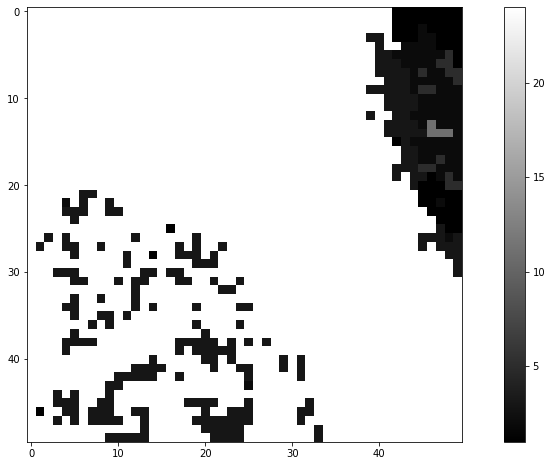

In [22]:
test = distance_merging_while(img_r, 0.1, img_small)
print(test)
ip.show_image(test, 15, 8)

#im = Image.fromarray(test)
#im.save("t01tifimg.tif")